# **General Information**

In this kernel, I will work on analyzing how NBA teams win, and figure out which aspects during the game helped them win. The data provides player information, over 25,000 game data and statistics, team ranking since 2003, and informations of all the 30 teams in the NBA.

# **Objectives**

1. Find out if teams has a better chance of winning during home games, and in which aspects help them achieve the victory.
2. Compare the performance of teams when they play during home games as opposed to away games. 
3. Analyze if arena capacity could help a home team win.


# **Importing Libraries, Functions, and Data**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

# **Data Loading and Overview**

Data is seperated in five datasets; Game information and statistics, Player informations, Team ranking, Team informations. This notebook primarily uses data from the game information.

In [2]:
games_df = pd.read_csv('/kaggle/input/nba-games/games.csv')
game_deets_df = pd.read_csv('/kaggle/input/nba-games/games_details.csv', low_memory=False)
players_df = pd.read_csv('/kaggle/input/nba-games/players.csv')
ranking_df = pd.read_csv('/kaggle/input/nba-games/ranking.csv')
teams_df = pd.read_csv('/kaggle/input/nba-games/teams.csv')
games_df['GAME_DATE_EST']= pd.to_datetime(games_df['GAME_DATE_EST'])
pd.set_option('display.max_columns',21)

def get_mean(group, column):
    return group[column].mean()
def get_2mean(df,first,second):
    return (df[first]/df[second]).mean()
def get_2median(df,first,second):
    return (df[first]/df[second]).median()

In [3]:
print(f'Game details has {game_deets_df.shape[0]} rows and {game_deets_df.shape[1]} columns')
print(f'Team games has {games_df.shape[0]} rows and {games_df.shape[1]} columns')
print(f'Player informations has {players_df.shape[0]} rows and {players_df.shape[1]} columns')
print(f'Team ranking has {ranking_df.shape[0]} rows and {ranking_df.shape[1]} columns')
print(f'Team information has {teams_df.shape[0]} rows and {teams_df.shape[1]} columns')

Game details has 645953 rows and 29 columns
Team games has 25796 rows and 21 columns
Player informations has 7228 rows and 4 columns
Team ranking has 201792 rows and 13 columns
Team information has 30 rows and 14 columns


In [4]:
wl_group = games_df.groupby(['HOME_TEAM_WINS'])

win_filt = wl_group.get_group(1)
lose_filt = wl_group.get_group(0)

reb_grp = games_df.groupby(['REB_home','HOME_TEAM_WINS'])
reb_table = reb_grp.size().unstack(fill_value=0)
losereb_grp = games_df.groupby(['REB_away','HOME_TEAM_WINS'])
losereb_table = losereb_grp.size().unstack(fill_value=0)
ast_grp = games_df.groupby(['AST_home','HOME_TEAM_WINS'])
mean_w_reb = get_mean(win_filt,'REB_home')
ast_table= ast_grp.size().unstack(fill_value=0)
lose_ast_grp = games_df.groupby(['AST_away','HOME_TEAM_WINS'])
lose_ast_table = lose_ast_grp.size().unstack(fill_value=0)
fgpct_grp = games_df.groupby(['FG_PCT_home','HOME_TEAM_WINS'])
fgpct_table = fgpct_grp.size().unstack(fill_value=0)
fgpct_grp_lose = games_df.groupby(['FG_PCT_away','HOME_TEAM_WINS'])
fgpct_away_table = fgpct_grp_lose.size().unstack(fill_value=0)
fg3pct_grp= games_df.groupby(['FG3_PCT_home','HOME_TEAM_WINS'])
fg3pct_table = fg3pct_grp.size().unstack(fill_value=0)
fg3pct_grp_lose = games_df.groupby(['FG3_PCT_away','HOME_TEAM_WINS'])
fg3pct_away_table = fg3pct_grp_lose.size().unstack(fill_value=0)
ast_reb_grp = games_df.groupby(['AST_home','REB_home','HOME_TEAM_WINS'])
ast_reb_table = ast_reb_grp.size().unstack(fill_value=0)
teams_grp = games_df.groupby(['HOME_TEAM_ID','HOME_TEAM_WINS'])
most_win_table = teams_grp['HOME_TEAM_WINS'].size().unstack(fill_value=0)
teams_df.sort_values(by='TEAM_ID',ascending = True,inplace = True)
most_win_table.sort_values(by='HOME_TEAM_ID',ascending = True,inplace = True)
most_win_table['NAME'] = teams_df['NICKNAME'].values
most_win_table['ARENA_CAP'] = teams_df['ARENACAPACITY'].values
most_win_table.sort_values(by='ARENA_CAP',ascending = False,inplace = True)


Code is hidden for all the groups and sorting made.

# **Data Exploration and Vizualization**

We will start with finding out the probability of teams winning home games as opposed to losing home games.

In [5]:
pct_home_win = games_df['HOME_TEAM_WINS'].value_counts()/len(games_df) * 100
print(f'Teams are likely to win {pct_home_win[1]:.2f}% during home games, and lose {pct_home_win[0]:.2f}% during home games')

Teams are likely to win 58.75% during home games, and lose 41.25% during home games


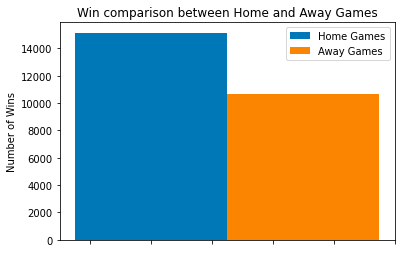

In [6]:
# do teams perform better when at home stadium?
#groupings and bar plot
x = win_filt['HOME_TEAM_WINS'].value_counts()
y = lose_filt['HOME_TEAM_WINS'].value_counts()

ti = [0.5]
hor = np.arange(len(ti))

plt.bar(ti,x,width = 0.25,color = '#0077b6',label = 'Home Games')
plt.bar(hor + 0.75,y,width = 0.25,color = '#fb8500',label = 'Away Games')

plt.ylabel('Number of Wins')
plt.xticks(color = 'w')
plt.title('Win comparison between Home and Away Games')
plt.legend()

This graph shows the correlation of winning and losing home and away games. It is evident that it is more likely to win Home games than winning away games. This could be due to:

1. Underlying statistics (ex: field goal percentage, number of assists)
2. Home game advantage (arena capacity)

Let us examine the statistics that could have caused the probability of winning more home games than winning away games

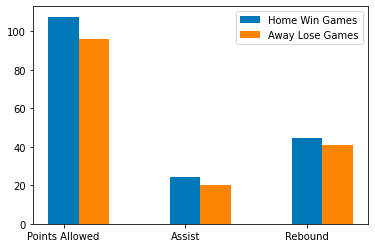

In [7]:
x = [get_mean(win_filt,'PTS_home'),get_mean(win_filt,'AST_home'),
     get_mean(win_filt,'REB_home')]
y = [get_mean(win_filt,'PTS_away'),get_mean(win_filt,'AST_away'),
     get_mean(win_filt,'REB_away')]

ti = ['Points Allowed','Assist','Rebound']
hor = np.arange(len(ti))

plt.bar(ti,x,width = 0.25,color = '#0077b6',label = 'Home Win Games')
plt.bar(hor + 0.25,y,width = 0.25,color = '#fb8500',label = 'Away Lose Games')
plt.legend()

We could see in the graph above that home win games has more points allowed, more assists, and more rebounds.

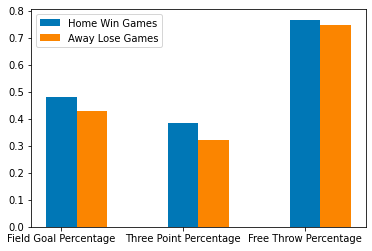

In [8]:
# plotting using the bar graph the difference between the fg pct and 3pt fg pct of home and away games
x = [get_mean(win_filt,'FG_PCT_home'),get_mean(win_filt,'FG3_PCT_home'),
    get_mean(win_filt,'FT_PCT_home')]
y = [get_mean(win_filt,'FG_PCT_away'),get_mean(win_filt,'FG3_PCT_away'),
    get_mean(win_filt,'FT_PCT_away')]
ti = ['Field Goal Percentage','Three Point Percentage','Free Throw Percentage']
hor = np.arange(len(ti))

plt.bar(ti,x,width = 0.25,color = '#0077b6',label = 'Home Win Games')
plt.bar(hor + 0.25,y,width = 0.25,color = '#fb8500',label = 'Away Lose Games')
plt.legend()

The same could be said in terms of the field goal percentage, three point percentage, and free throw percentage. 

We could conclude that having home games make a significant change on the performance of the team such as in terms of the fg pct, 3pt pct, points allowed, assists made and rebounds made. However, to solidify this claim, let us compare the stats of those who won home and away games.

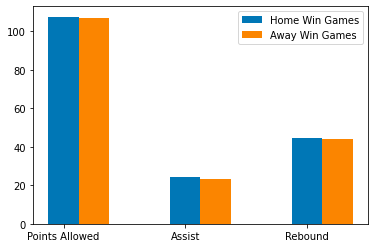

In [9]:
x = [get_mean(win_filt,'PTS_home'),get_mean(win_filt,'AST_home'),
    get_mean(win_filt,'REB_home')]
y = [get_mean(lose_filt,'PTS_away'),get_mean(lose_filt,'AST_away'),
    get_mean(lose_filt,'REB_away')]

ti = ['Points Allowed','Assist','Rebound']
hor = np.arange(len(ti))

plt.bar(ti,x,width = 0.25,color = '#0077b6',label = 'Home Win Games')
plt.bar(hor + 0.25,y,width = 0.25,color = '#fb8500',label = 'Away Win Games')
plt.legend()

In the graph above, we could notice that the points allowed, assists made, and rebounds made are almost identical.

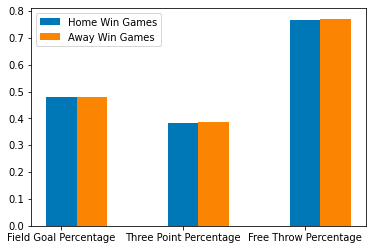

In [10]:
x = [get_mean(win_filt,'FG_PCT_home'),get_mean(win_filt,'FG3_PCT_home'),
    get_mean(win_filt,'FT_PCT_home')]
y = [get_mean(lose_filt,'FG_PCT_away'),get_mean(lose_filt,'FG3_PCT_away'),
    get_mean(lose_filt,'FT_PCT_away')]

ti = ['Field Goal Percentage','Three Point Percentage','Free Throw Percentage']
hor = np.arange(len(ti))

plt.bar(ti,x,width = 0.25,color = '#0077b6',label = 'Home Win Games')
plt.bar(hor + 0.25,y,width = 0.25,color = '#fb8500',label = 'Away Win Games')
plt.legend()

based on both of these graph, we could conclude that both the winners of home games and winners of away games have identical stats.

Out of all these stats, let us find out which contributed more in winning games.

<function matplotlib.pyplot.show(close=None, block=None)>

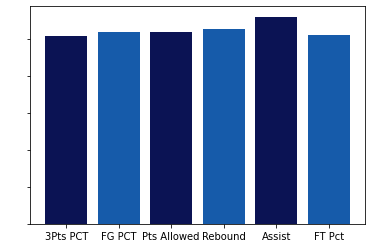

In [11]:
fg_3pct = get_2median(games_df,'FG3_PCT_home','FG3_PCT_away')
fg_pct = get_2mean(games_df,'FG_PCT_home','FG_PCT_away')
pts_allowed = get_2mean(games_df,'PTS_home','PTS_away')
reb = get_2mean(games_df,'REB_home','REB_away')
ast = get_2mean(games_df,'AST_home','AST_away')
free_throw = get_2mean(games_df,'FT_PCT_home','FT_PCT_away')

#making the plot
x = [fg_3pct,fg_pct,pts_allowed,reb,ast,free_throw]
y = ['3Pts PCT','FG PCT','Pts Allowed','Rebound','Assist','FT Pct']

plt.yticks(color = 'w')
plt.bar(y,x,color = ['#0b1354','#165baa'])
plt.show

We can notice that having more assists could contribute more to winning games. It is followed by rebounds made, points allowed and field goal percentage, 3 points percentage, and lastly, free throw percentage.

In [12]:
# how much assists is it more likely to win
ast_grp = games_df.groupby(['AST_home','HOME_TEAM_WINS'])

mean_w_ast = get_mean(win_filt,'AST_home')
mean_l_ast = get_mean(lose_filt,'AST_home')
ptdif_w_ast = get_mean(win_filt,'PTS_home') - get_mean(win_filt,'PTS_away')

mean_w_reb = get_mean(win_filt,'REB_home')
mean_l_reb = get_mean(lose_filt,'REB_home')
ptdif_w_reb = win_filt['REB_home'] - win_filt['REB_away']
print(f' the mean amount of assists made by teams who won home games is {mean_w_ast:.0f}, and the mean amount of assists made by teams who lost home games is {mean_l_ast:.0f}')
print(f' the mean amount of assists made by teams who won home games is {mean_w_reb:.0f}, and the mean amount of assists made by teams who lost home games is {mean_l_reb:.0f}')

 the mean amount of assists made by teams who won home games is 24, and the mean amount of assists made by teams who lost home games is 21
 the mean amount of assists made by teams who won home games is 45, and the mean amount of assists made by teams who lost home games is 41


Let us dig deeper on these statistics by comparing the stats of those who won and lost home games, and those who won and lost away games. Firstly, let us check the rebounds made by those who won and lost home and away games.

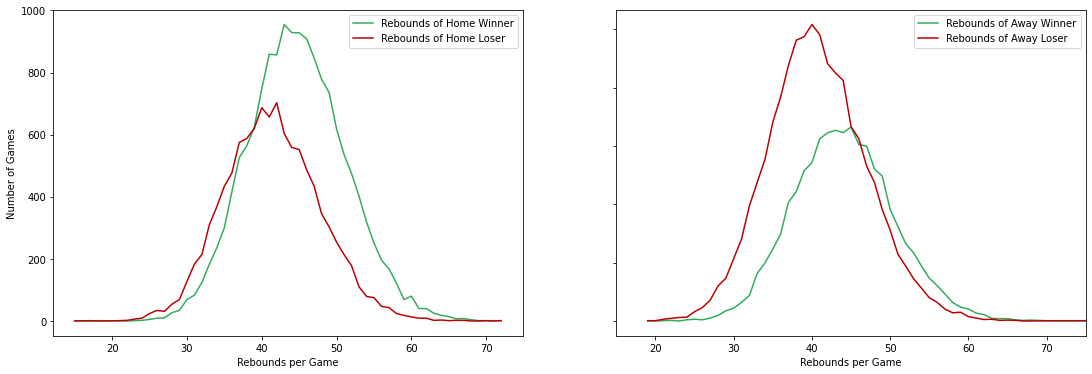

In [13]:
# compare it with rebounds of loser and winner
reb_grp = games_df.groupby(['REB_home','HOME_TEAM_WINS'])
reb_table = reb_grp.size().unstack(fill_value=0)

# assigning the amount of rebounds the winner and loser has
plt.subplot(1,2,1)
plt.plot(reb_table[1], color = '#33AB5F',label = 'Rebounds of Home Winner')
plt.plot(reb_table[0], color = '#BA0001',label = 'Rebounds of Home Loser')

plt.ylabel('Number of Games')
plt.xlabel('Rebounds per Game')
plt.legend()

# compare the results from those who won and lost during home and away games
plt.subplot(1,2,2)
losereb_grp = games_df.groupby(['REB_away','HOME_TEAM_WINS'])
losereb_table = losereb_grp.size().unstack(fill_value=0)

plt.plot(losereb_table[0], color = '#33AB5F',label = 'Rebounds of Away Winner')
plt.plot(losereb_table[1], color = '#BA0001',label = 'Rebounds of Away Loser')

plt.yticks(c='w')
plt.xlim([15,75])
fig = plt.gcf()
fig.set_size_inches(18.5,6)
plt.xlabel('Rebounds per Game')
plt.legend()

on the first graph (left), we can notice that the more rebounds a team makes, the more it is likely for them to win. It also translate to the mean number of rebounds of home winner which is 44 rebounds a game, as opposed to those who lost home games with 41.4 rebounds a game.

on the second graph (right), it is shown that teams who has less rebounds are more likely to lose away games. Away games winner has 44 rebounds a game, and 40.7 rebounds for those who lost away games. 

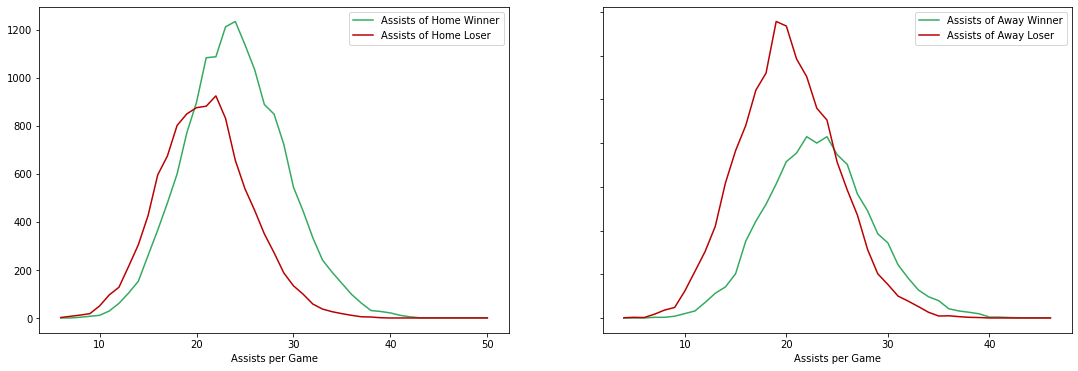

In [14]:
# grouped the home team wins with the 0 and 1 (could do this with everything else)
ast_table= ast_grp.size().unstack(fill_value=0)

#plot it using line graph
plt.subplot(1,2,1)

plt.plot(ast_table[1], color = '#33AB5F',label = 'Assists of Home Winner')
plt.plot(ast_table[0], color = '#BA0001',label = 'Assists of Home Loser')

plt.xlabel('Assists per Game')
plt.legend()

# compare the results from those who won and lose during an away game
plt.subplot(1,2,2)
lose_ast_grp = games_df.groupby(['AST_away','HOME_TEAM_WINS'])
lose_ast_table = lose_ast_grp.size().unstack(fill_value=0)

plt.plot(lose_ast_table[0], color = '#33AB5F',label = 'Assists of Away Winner')
plt.plot(lose_ast_table[1], color = '#BA0001',label = 'Assists of Away Loser')

plt.yticks(c='w')
plt.xlabel('Assists per Game')
fig = plt.gcf()
fig.set_size_inches(18.5,6)
plt.legend()

On the first graph (left), it is shown that the more assists a team does, the more it is likely for them to win. the mean amount of the assists made by teams who won home games is 24.05, while those who lost home games has 20.85 assists. 

The same could be said (right) for those who won away games, they are more likely to win games by having more assists than their opponent. Away winners usually has 23.22 assists and those who lost away games usually has 20.14 assists

This supports our claim that the more rebounds and assists a team makes in a game, this increases their chances of winning.

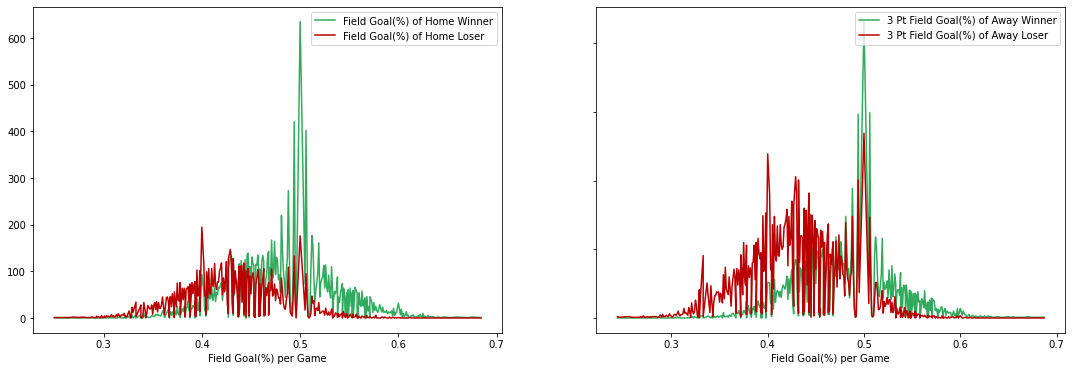

In [15]:
#grouping and making the table for fg pct and 3ptpct
fgpct_grp = games_df.groupby(['FG_PCT_home','HOME_TEAM_WINS'])
fgpct_table = fgpct_grp.size().unstack(fill_value=0)
fgpct_grp_lose = games_df.groupby(['FG_PCT_away','HOME_TEAM_WINS'])
fgpct_away_table = fgpct_grp_lose.size().unstack(fill_value=0)

fg3pct_grp= games_df.groupby(['FG3_PCT_home','HOME_TEAM_WINS'])
fg3pct_table = fg3pct_grp.size().unstack(fill_value=0)
fg3pct_grp_lose = games_df.groupby(['FG3_PCT_away','HOME_TEAM_WINS'])
fg3pct_away_table = fg3pct_grp_lose.size().unstack(fill_value=0)

plt.subplot(1,2,1)

plt.plot(fgpct_table[1], color = '#33AB5F',label = 'Field Goal(%) of Home Winner')
plt.plot(fgpct_table[0], color = '#BA0001',label = 'Field Goal(%) of Home Loser')

plt.xlabel('Field Goal(%) per Game') 
plt.legend(loc = 'upper right')

plt.subplot(1,2,2)

plt.plot(fgpct_away_table[0], color = '#33AB5F',label = '3 Pt Field Goal(%) of Away Winner')
plt.plot(fgpct_away_table[1], color = '#BA0001',label = '3 Pt Field Goal(%) of Away Loser')

plt.yticks(c='w')
fig = plt.gcf()
fig.set_size_inches(18.5,6)
plt.xlabel('Field Goal(%) per Game') 
plt.legend(loc = 'upper right')

In both of these graphs, we compared the field goal percentage of teams who won and lost home and away games. On our first graph it is shown that having a FG% of 50 during home games would almost guarantee a win. However, by playing in away games, having a 50% Field Goal Percentage would still indicate a likelyhood of winning the game but having more rebound or assist increase this chance exponentially.

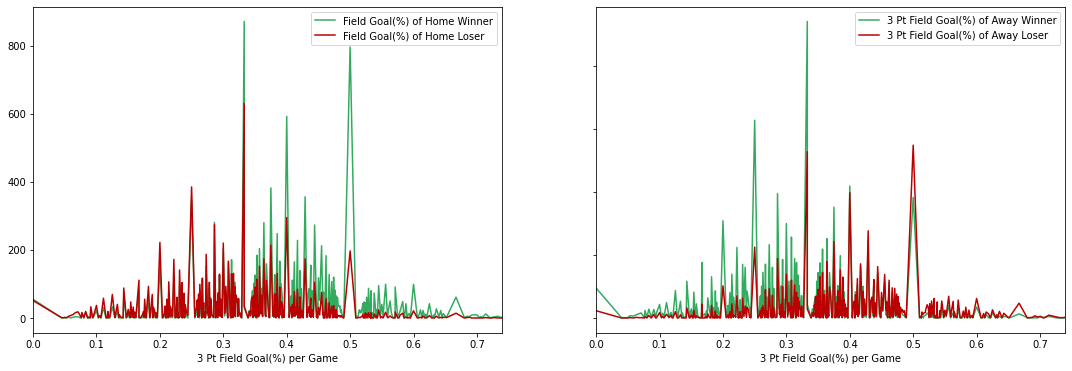

In [16]:
# plot fg pct
plt.subplot(1,2,1)

plt.plot(fg3pct_table[1], color = '#33AB5F',label = 'Field Goal(%) of Home Winner')
plt.plot(fg3pct_table[0], color = '#BA0001',label = 'Field Goal(%) of Home Loser')

plt.xlabel('3 Pt Field Goal(%) per Game') 
plt.legend(loc = 'upper right')
plt.xlim([0,0.74])
#plot 3pt pct
plt.subplot(1,2,2)

plt.plot(fg3pct_away_table[1], color = '#33AB5F',label = '3 Pt Field Goal(%) of Away Winner')
plt.plot(fg3pct_away_table[0], color = '#BA0001',label = '3 Pt Field Goal(%) of Away Loser')

plt.yticks(c='w')
plt.xlim([0,0.74])
fig = plt.gcf()
fig.set_size_inches(18.5,6)
plt.xlabel('3 Pt Field Goal(%) per Game') 
plt.legend(loc = 'upper right')

The two graphs above shows the difference in terms of the three point percentage by the teams who won and lost home and away games. On the first graph (left), it is shown that having a percentage of 50, 40, and 30 has the highest number of winners during home games, the chances of winning during home games increases when a team reaches 50% 3 point field goal. 

On the second graph (right), there are more teams who lost when they had 50% 3 point field goal percentage. This could be an indicator of other stats falling behind, those teams could have less assists or rebounds which could result in a lose.

In [17]:
# now combine the mean rebounds and assists of the winning team and look at pct of winning 
# by having the same amount of the said mean of the two variables

ast_reb_grp = games_df.groupby(['AST_home','REB_home','HOME_TEAM_WINS'])
ast_reb_table = ast_reb_grp.size().unstack(fill_value=0)

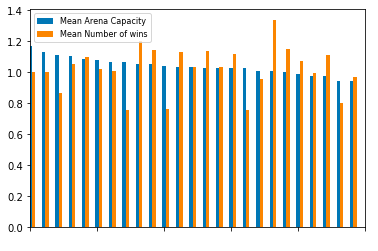

In [18]:
# teams with most wins
teams_grp = games_df.groupby(['HOME_TEAM_ID','HOME_TEAM_WINS'])
most_win_table = teams_grp['HOME_TEAM_WINS'].size().unstack(fill_value=0)
teams_df.sort_values(by='TEAM_ID',ascending = True,inplace = True)
most_win_table.sort_values(by='HOME_TEAM_ID',ascending = True,inplace = True)
most_win_table['NAME'] = teams_df['NICKNAME'].values
most_win_table['ARENA_CAP'] = teams_df['ARENACAPACITY'].values
most_win_table.sort_values(by='ARENA_CAP',ascending = False,inplace = True)

# got the most wins gotten by an NBA team since 2003 (most_win_table)
most_win_table['MEAN_ARENA_CAP']=[x/18553.31 for x in most_win_table['ARENA_CAP']]
most_win_table['MEAN_WINS']=[x/505.17 for x in most_win_table[1]]

# 18553.31 mean number of arena capacity
# average wins per team is 505.17 wins

#plot of the relation of arena capacity to number of wins
ti = [x for x in range(30)]
hor = np.arange(len(ti))

x = [x for x in most_win_table['MEAN_ARENA_CAP']]
y = [x for x in most_win_table['MEAN_WINS']]

plt.bar(ti,x,width = 0.25,color = '#0077b6',label = 'Mean Arena Capacity')
plt.bar(hor + 0.25,y,width = 0.25,color = '#fb8500',label = 'Mean Number of wins')

plt.xlim(0,25)
plt.xticks(color='w')
plt.legend(loc = 'upper left',fontsize = 8)

Based on the graph above, we could see low number arena capacity but has more wins while some of the higher capacity arenas has lower wins than those with lower capacity, we can therefore conclude that arena capacity doesn't have any correlations with winning

# **Conclusions and Findings**
1. Teams has a better chance of winning when they are at Home Arenas.
2. Teams has a more likelihood of winning when they have more assists, followed by having more rebounds,  field goal percentage, 3 points percentage, and lastly, free throw percentage, respectively.
3. Teams who won during home games has identical stats with those who won away games, the same could be said for those who lost during home and away games.
4. Arena Capacity doesn't play any role on the probability of teams winning.
